In [1]:
#These are the standard definitions and imports for our code
import sys
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd  # Ensure pandas is imported
import generic_potential_modified
import tunneling1D_modified as tunneling1D
from cosmoTransitions import pathDeformation as pd_cosmo  # Avoid alias conflict

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

def get_f_max_and_width(b, c):
    T_c = 1 / np.sqrt(2 * (c - b**2))
    phi_minus = (-3 * b * T_c - np.sqrt(9 * b**2 * T_c**2 + 4 * (1 - 2 * c * T_c**2))) / 2
    Vtot = (-.5 + c * T_c**2) * phi_minus**2 + b * T_c * phi_minus**3 + .25 * phi_minus**4
    f_max = (Vtot / T_c**4) / 10
    width = 2 * phi_minus
    return f_max, width

class model1(generic_potential_modified.generic_potential):
    def init(self, a, b, c, Lambda, c1, f, width, **kwargs):
        self.Ndim = 1
        self.deriv_order = 2
        self.Tmax = 2.
        self.a = a
        self.b = b
        self.c = c
        self.Lambda = Lambda
        self.c1 = c1
        self.f = f
        self.width = width

    def approxZeroTMin(self):
        approxZeroGuess = 1.**2
        return [np.ones(self.Ndim) * approxZeroGuess**.5]

    def Vtot(self, X, T, include_radiation=True):
        X = np.asanyarray(X)
        phi = X[..., 0]
        w = (1 - 1 / (1 + np.exp(-self.c1 * (phi - self.width / 2)))) / (1 + np.exp(-self.c1 * (phi + self.width / 2)))
        w_0 = (1 - 1 / (1 + np.exp(-self.c1 * (0 - self.width / 2)))) / (1 + np.exp(-self.c1 * (0 + self.width / 2)))
        return ((-0.5 + self.c * T**2) * phi**2 + self.b * T * phi**3 + (0.25 + self.a) * phi**4 + self.f * T**4 * (w - w_0))

def get_profile(phi_vals, V_vals, guesses=(5, 0)):
    f = interpolate.UnivariateSpline(phi_vals, V_vals, s=0, k=4)
    df = f.derivative(1)
    d2f = f.derivative(2)
    inst = tunneling1D.SingleFieldInstanton(*guesses, f, df, d2f)
    profile = inst.findProfile()
    action = inst.findAction(profile)
    return profile, action

def get_thermal_params(Tnuc, f, param_instance):
    param_instance['f'] = f
    with HiddenPrints():
        try:
            m = model1(**param_instance)
            m.findAllTransitions(tunnelFromPhase_args={'verbose': False, 'fullTunneling_params': {'verbose': True}})
        except Exception as e:
            print(f"Error in model initialization or transition finding: {e}")
            return None

    try:
        trans_i = -1
        for Ti in range(np.size(m.TnTrans)):
            if m.TnTrans[Ti]['low_vev'][0] - m.TnTrans[Ti]['high_vev'][0] > 0:
                trans_i = Ti
        if trans_i == -1:
            print('No valid transition found')
            return None
        high_vev = m.TnTrans[trans_i]['high_vev'][0]
        low_vev = m.TnTrans[trans_i]['low_vev'][0]

        phis = np.linspace(high_vev - np.abs(high_vev), low_vev + np.abs(low_vev), num=10000)
        guesses = (low_vev + 0.01 * np.abs(low_vev), high_vev - 0.01 * np.abs(high_vev))
        V_vals = m.Vtot(np.array([phis]).T, Tnuc)
        profile, action = get_profile(phis, V_vals, guesses=guesses)
        ST = action / Tnuc

        # Calculate deltaV and its derivative
        Ts = np.linspace(Tnuc * 0.99, Tnuc * 1.01, num=100)
        deltaVs = np.array([m.Vtot(np.reshape(profile.Phi[-1], (1, 1)), T) - m.Vtot(np.reshape(profile.Phi[0], (1, 1)), T) for T in Ts])
        
        delV_spline = interpolate.UnivariateSpline(Ts, deltaVs, s=0, k=4)
        delV = delV_spline(Tnuc)
        ddelVdT = delV_spline.derivative(1)(Tnuc)

        # Correct calculation of rho_n
        rho_n = np.pi**2 * 10 * Tnuc**4 / 3

        ksi = 1 / rho_n * (delV - Tnuc * ddelVdT)

        # Calculate betaH
        try:
            action_Ts = np.array([get_profile(phis, m.Vtot(np.array([phis]).T, T), guesses)[1] for T in Ts])
            ST_spline = interpolate.UnivariateSpline(Ts, action_Ts / Ts, s=0, k=4)
            dSTdT = ST_spline.derivative(1)(Tnuc)
            betaH = dSTdT(Tnuc) * Tnuc
        except Exception as e:
            print(f'Error calculating betaH: {e}')
            betaH = 0

        return {
            'Tnucs': Tnuc,
            'betaHs': betaH,
            'ksis': ksi,
            'delV': delV,
            'ddelVdT': ddelVdT,
            'actions': action,
            'ST': ST
        }

    except Exception as e:
        print(f"Error in thermal parameter calculation: {e}")
        return None

# Seed with b, c, and analytic_tnuc from the analytic solution at f=0. 
# Shift f by some delta f
set_b = -1.54833
set_c = 4.51082
analytic_tnuc = 0.4553071346353729 

# Generate f values from 0.1 to 1.0
fs = np.arange(0.1, 1.1, 0.1)  


#Calculate the thermal parameters for a range of fs near f=0
def ideal_thermal_params(set_b, set_c, analytic_tnuc, fs):
    param_instance = {
        'a': 0,
        'b': set_b,
        'c': set_c,
        'Lambda': 1.,
        'c1': 20.,
        'f': 0,
        'width': get_f_max_and_width(set_b, set_c)[1]
    }

    all_thermal_params = []
    # Start with the analytic solution
    estimated_tnuc = analytic_tnuc  

    for f in fs:
        iteration = 0
        #After shifting f away from zero by our prescibed amount, we'll try to shift Tnuc by this initial amount
        adjustment_step = 0.005
        #We'll set a lower limit to avoid infinite iteration
        min_adjustment_step = 0.0001
         #Initialize to avoid UnboundLocalError (this is a hack for an error I don't really understand)
        interpolated_thermal_params = None

        while True:
            iteration += 1
            print(f"Iteration {iteration} for f={f}:")
            print(f"Current Tnuc: {estimated_tnuc}")
            
            # Calculate thermal params for the given f, Tnuc combo
            param_instance['f'] = f
            thermal_params = get_thermal_params(estimated_tnuc, f, param_instance)
            if thermal_params is None:
                print("Error calculating thermal parameters.")
                break

            priori_tnuc = thermal_params['Tnucs']
            calculated_st = thermal_params['ST']
            print(f"Calculated S/T: {calculated_st}")
            
            # Adjust Tnuc
            adjusted_tnuc = priori_tnuc + adjustment_step

            # Calculate params for this adjusted Tnuc
            param_instance['width'] = get_f_max_and_width(set_b, set_c)[1]
            thermal_params2 = get_thermal_params(adjusted_tnuc, f, param_instance)
            if thermal_params2 is None:
                print("Error calculating thermal parameters for adjusted Tnuc.")
                #If we fail to produce thermal parameters, let's try to adjust Tnuc by some smaller amount
                adjustment_step = .8 * adjustment_step 
                if adjustment_step < min_adjustment_step:
                    print("Minimum adjustment step size reached, exiting loop.")
                    break
                continue

            adjusted_st = thermal_params2['ST']
            #print(f"Adjusted S/T: {adjusted_st}\n\n")

            # Use linear interpolation to estimate Tnuc such that S/T is closer to 140
            try:
                estimate_tnuc = priori_tnuc + (140 - calculated_st) * ((adjusted_tnuc - priori_tnuc) / (adjusted_st - calculated_st))
                interpolated_thermal_params = get_thermal_params(estimate_tnuc, f, param_instance)
                if interpolated_thermal_params is None:
                    print("Error calculating interpolated thermal parameters.")
                    #If we fail, retry with smaller adjustment
                    adjustment_step = .8 * adjustment_step  
                    if adjustment_step < min_adjustment_step:
                        print("Minimum adjustment step size reached, exiting loop.")
                        break
                    continue

                estimate_st = interpolated_thermal_params['ST']
                print(f"Estimated Tnuc: {estimate_tnuc}")
                print(f"Estimated S/T: {estimate_st}\n")
            except Exception as e:
                print(f"Error during interpolation: {e}")
                #If we fail, retry with smaller adjustment
                adjustment_step = .8 * adjustment_step
                if adjustment_step < min_adjustment_step:
                    print("Minimum adjustment step size reached, exiting loop.")
                    break
                continue

            # Track the differences in S/T
            #I don't think the min will ever be with the adjusted st. Track for rigor?
            combo_1_diff = np.abs(140 - calculated_st)
            combo_2_diff = np.abs(140 - adjusted_st)
            combo_3_diff = np.abs(140 - estimate_st)

            diffs = [combo_1_diff, combo_2_diff, combo_3_diff]
            
            # Break the loop when the difference is within the threshold
            if any(diff < 1 for diff in diffs):
                print(f"Target Tnuc for f={f}: {estimate_tnuc}")
                # Use the estimated Tnuc as the seed Tnuc for the next f value
                estimated_tnuc = estimate_tnuc 
                break

            # Use old estimate as new seed
            estimated_tnuc = estimate_tnuc
            
            # Dodge infinite loop
            if iteration > 10:  
                print("Exceeded maximum iterations, exiting loop.")
                break

        if interpolated_thermal_params is not None:
            all_thermal_params.append({
                'f': f,
                'Tnucs': interpolated_thermal_params['Tnucs'],
                'betaHs': interpolated_thermal_params['betaHs'],
                'ksis': interpolated_thermal_params['ksis'],
                'delV': interpolated_thermal_params['delV'],
                'ddelVdT': interpolated_thermal_params['ddelVdT'],
                'actions': interpolated_thermal_params['actions'],
                'ST': interpolated_thermal_params['ST']
            })

    return all_thermal_params

# Calculate the thermal parameters for the range of f values
thermal_params_list = ideal_thermal_params(set_b, set_c, analytic_tnuc, fs)

# Convert to a Pandas DataFrame for easier manipulation and saving
df_thermal_params = pd.DataFrame(thermal_params_list)

print(df_thermal_params)

Iteration 1 for f=0.1:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 147.7774210395705
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters for adjusted Tnuc.
Iteration 2 for f=0.1:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 147.7774210395705
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters for adjusted Tnuc.
Iteration 3 for f=0.1:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 147.7774210395705
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters for adjusted Tnuc.
Iteration 4 for f=0.1:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calcul

C:\Users\jowar\GWfFOPT\tunneling1D_modified.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=0.7000000000000001:
Current Tnuc: 0.45897296812155003
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=0.8:
Current Tnuc: 0.45897296812155003
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=0.9:
Current Tnuc: 0.45897296812155003
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=1.0:
Current Tnuc: 0.45897296812155003
No valid transition found
Error calculating thermal parameters.
     f     Tnucs  betaHs      ksis                 delV              ddelVdT  \
0  0.1  0.454283       0  1.409946  0.14514387667559825   -4.029220334225966   
1  0.2  0.455403       0  1.393819  0.14488539479762796   -4.

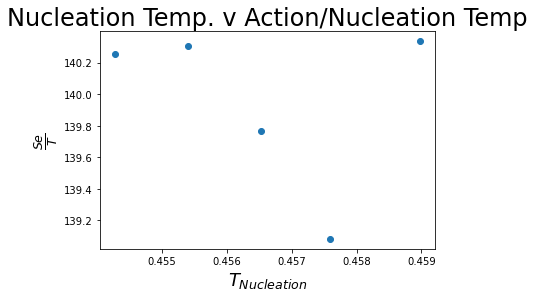

In [2]:
#print(len(df_thermal_params['Tnucs']), len(df_thermal_params['ST']))
plt.scatter(df_thermal_params['Tnucs'], df_thermal_params['ST'])
plt.title('Nucleation Temp. v Action/Nucleation Temp', size=24)
plt.xlabel(r'$T_{Nucleation}$', size=18)
plt.ylabel(r'$\frac{Se}{T}$', size=18)
plt.show()

In [3]:
# Calculate slopes
slope_list = []
for i in range(1, len(df_thermal_params['ST'])):
    slope = (df_thermal_params['ST'][i] - df_thermal_params['ST'][i-1]) / (df_thermal_params['Tnucs'][i] - df_thermal_params['Tnucs'][i-1])
    slope_list.append(slope)
    
print("Slopes:", slope_list)

# Calculate Beta_H
Beta_H_list = []
for i in range(len(slope_list)):
    Beta_H = slope_list[i] * df_thermal_params['Tnucs'][i+1]
    Beta_H_list.append(Beta_H)
    
print("Beta_H values:", Beta_H_list)

# Calculate h^2 Omega and f_SW
h_2_omega_list = []
f_SW_list = []
for i in range(len(Beta_H_list)):
    h_2_omega = (8.5 * 10**-6) * df_thermal_params['ksis'][i+1]**4 * Beta_H_list[i]**-1
    f_sw = (8.9 * 10**-3) * Beta_H_list[i]
    f_SW = f_sw * df_thermal_params['Tnucs'][i+1] / 100
    h_2_omega_list.append(h_2_omega)
    f_SW_list.append(f_SW)
    
print("h^2 Omega values:", h_2_omega_list)
print("f_SW values:", f_SW_list)


Slopes: [42.23992247386502, -471.71952819619537, -644.0826202463628, 910.1304801662931]
Beta_H values: [19.236201530080127, -215.3552217173247, -294.7306088460215, 417.72528785981507]
h^2 Omega values: [1.667726181907169e-06, -1.4216671054733624e-07, -9.913847879080174e-08, 6.644601585214507e-08]
f_SW values: [0.000779660497923444, -0.008750179542376215, -0.012003251580393965, 0.01706349075533189]


Iteration 1 for f=0.1:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 147.7774210395705
Adjusted Tnuc:  0.4603071346353729
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters for adjusted Tnuc.
Iteration 2 for f=0.1:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 147.7774210395705
Adjusted Tnuc:  0.4593071346353729
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters for adjusted Tnuc.
Iteration 3 for f=0.1:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 147.7774210395705
Adjusted Tnuc:  0.4585071346353729
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters for adjusted Tnuc.
Iteration 4 for f=0.1:

C:\Users\jowar\GWfFOPT\tunneling1D_modified.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=0.7000000000000001:
Current Tnuc: 0.45897296812155003
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=0.8:
Current Tnuc: 0.45897296812155003
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=0.9:
Current Tnuc: 0.45897296812155003
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=1.0:
Current Tnuc: 0.45897296812155003
No valid transition found
Error calculating thermal parameters.
     f     Tnucs  betaHs      ksis                 delV              ddelVdT  \
0  0.1  0.454283       0  1.409946  0.14514387667559825   -4.029220334225966   
1  0.2  0.455403       0  1.393819  0.14488539479762796   -4.

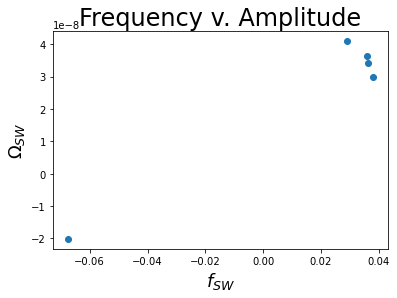

In [4]:
import sys
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
import generic_potential_modified
import tunneling1D_modified as tunneling1D
from cosmoTransitions import pathDeformation as pd_cosmo  # Avoid alias conflict

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

def get_f_max_and_width(b, c):
    T_c = 1 / np.sqrt(2 * (c - b**2))
    phi_minus = (-3 * b * T_c - np.sqrt(9 * b**2 * T_c**2 + 4 * (1 - 2 * c * T_c**2))) / 2
    Vtot = (-.5 + c * T_c**2) * phi_minus**2 + b * T_c * phi_minus**3 + .25 * phi_minus**4
    f_max = (Vtot / T_c**4) / 10
    width = 2 * phi_minus
    return f_max, width

class model1(generic_potential_modified.generic_potential):
    def init(self, a, b, c, Lambda, c1, f, width, **kwargs):
        self.Ndim = 1
        self.deriv_order = 2
        self.Tmax = 2.
        self.a = a
        self.b = b
        self.c = c
        self.Lambda = Lambda
        self.c1 = c1
        self.f = f
        self.width = width

    def approxZeroTMin(self):
        approxZeroGuess = 1.**2
        return [np.ones(self.Ndim) * approxZeroGuess**.5]

    def Vtot(self, X, T, include_radiation=True):
        X = np.asanyarray(X)
        phi = X[..., 0]
        w = (1 - 1 / (1 + np.exp(-self.c1 * (phi - self.width / 2)))) / (1 + np.exp(-self.c1 * (phi + self.width / 2)))
        w_0 = (1 - 1 / (1 + np.exp(-self.c1 * (0 - self.width / 2)))) / (1 + np.exp(-self.c1 * (0 + self.width / 2)))
        return ((-0.5 + self.c * T**2) * phi**2 + self.b * T * phi**3 + (0.25 + self.a) * phi**4 + self.f * T**4 * (w - w_0))

def get_profile(phi_vals, V_vals, guesses=(5, 0)):
    f = interpolate.UnivariateSpline(phi_vals, V_vals, s=0, k=4)
    df = f.derivative(1)
    d2f = f.derivative(2)
    inst = tunneling1D.SingleFieldInstanton(*guesses, f, df, d2f)
    profile = inst.findProfile()
    action = inst.findAction(profile)
    return profile, action

def get_thermal_params(Tnuc, f, param_instance):
    param_instance['f'] = f
    with HiddenPrints():
        try:
            m = model1(**param_instance)
            m.findAllTransitions(tunnelFromPhase_args={'verbose': False, 'fullTunneling_params': {'verbose': True}})
        except Exception as e:
            print(f"Error in model initialization or transition finding: {e}")
            return None

    try:
        trans_i = -1
        for Ti in range(np.size(m.TnTrans)):
            if m.TnTrans[Ti]['low_vev'][0] - m.TnTrans[Ti]['high_vev'][0] > 0:
                trans_i = Ti
        if trans_i == -1:
            print('No valid transition found')
            return None
        high_vev = m.TnTrans[trans_i]['high_vev'][0]
        low_vev = m.TnTrans[trans_i]['low_vev'][0]

        phis = np.linspace(high_vev - np.abs(high_vev), low_vev + np.abs(low_vev), num=10000)
        guesses = (low_vev + 0.01 * np.abs(low_vev), high_vev - 0.01 * np.abs(high_vev))
        V_vals = m.Vtot(np.array([phis]).T, Tnuc)
        profile, action = get_profile(phis, V_vals, guesses=guesses)
        ST = action / Tnuc

        # Calculate deltaV and its derivative
        Ts = np.linspace(Tnuc * 0.99, Tnuc * 1.01, num=100)
        deltaVs = np.array([m.Vtot(np.reshape(profile.Phi[-1], (1, 1)), T) - m.Vtot(np.reshape(profile.Phi[0], (1, 1)), T) for T in Ts])
        
        delV_spline = interpolate.UnivariateSpline(Ts, deltaVs, s=0, k=4)
        delV = delV_spline(Tnuc)
        ddelVdT = delV_spline.derivative(1)(Tnuc)

        # Correct calculation of rho_n
        rho_n = np.pi**2 * 10 * Tnuc**4 / 3

        ksi = 1 / rho_n * (delV - Tnuc * ddelVdT)

        # Calculate betaH
        try:
            action_Ts = np.array([get_profile(phis, m.Vtot(np.array([phis]).T, T), guesses)[1] for T in Ts])
            ST_spline = interpolate.UnivariateSpline(Ts, action_Ts / Ts, s=0, k=4)
            dSTdT = ST_spline.derivative(1)(Tnuc)
            betaH = dSTdT(Tnuc) * Tnuc
        except Exception as e:
            print(f'Error calculating betaH: {e}')
            betaH = 0

        return {
            'Tnucs': Tnuc,
            'betaHs': betaH,
            'ksis': ksi,
            'delV': delV,
            'ddelVdT': ddelVdT,
            'actions': action,
            'ST': ST
        }

    except Exception as e:
        print(f"Error in thermal parameter calculation: {e}")
        return None

# Seed with b, c, and analytic_tnuc from the analytic solution at f=0. 
# Shift f by some delta f
set_b = -1.54833
set_c = 4.51082
analytic_tnuc = 0.4553071346353729 

# Generate f values from 0.1 to 1.0
fs = np.arange(0.1, 1.1, 0.1)  

# Calculate the thermal parameters for a range of fs near f=0
def ideal_thermal_params(set_b, set_c, analytic_tnuc, fs):
    param_instance = {
        'a': 0,
        'b': set_b,
        'c': set_c,
        'Lambda': 1.,
        'c1': 20.,
        'f': 0,
        'width': get_f_max_and_width(set_b, set_c)[1]
    }

    all_thermal_params = []
    # Start with the analytic solution
    estimated_tnuc = analytic_tnuc  

    for f in fs:
        iteration = 0
        # After shifting f away from zero by our prescribed amount, we'll try to shift Tnuc by this initial amount
        adjustment_step = 0.005
        # We'll set a lower limit to avoid infinite iteration
        min_adjustment_step = 0.0001
        # Initialize to avoid UnboundLocalError (this is a hack for an error I don't really understand)
        interpolated_thermal_params = None

        initial_calculated_st = None

        while True:
            iteration += 1
            print(f"Iteration {iteration} for f={f}:")
            print(f"Current Tnuc: {estimated_tnuc}")
            
            # Calculate thermal params for the given f, Tnuc combo
            param_instance['f'] = f
            thermal_params = get_thermal_params(estimated_tnuc, f, param_instance)
            if thermal_params is None:
                print("Error calculating thermal parameters.")
                break

            priori_tnuc = thermal_params['Tnucs']
            calculated_st = thermal_params['ST']
            if initial_calculated_st is None:
                initial_calculated_st = calculated_st
            print(f"Calculated S/T: {calculated_st}")
            
            # Adjust Tnuc
            adjusted_tnuc = priori_tnuc + adjustment_step
            print('Adjusted Tnuc: ', adjusted_tnuc)

            # Calculate params for this adjusted Tnuc
            param_instance['width'] = get_f_max_and_width(set_b, set_c)[1]
            thermal_params2 = get_thermal_params(adjusted_tnuc, f, param_instance)
            if thermal_params2 is None:
                print("Error calculating thermal parameters for adjusted Tnuc.")
                # If we fail to produce thermal parameters, let's try to adjust Tnuc by some smaller amount
                adjustment_step = .8 * adjustment_step 
                if adjustment_step < min_adjustment_step:
                    print("Minimum adjustment step size reached, exiting loop.")
                    break
                continue

            adjusted_st = thermal_params2['ST']
            print(f"Adjusted S/T: {adjusted_st}\n\n")

            # Use linear interpolation to estimate Tnuc such that S/T is closer to 140
            try:
                estimate_tnuc = priori_tnuc + (140 - calculated_st) * ((adjusted_tnuc - priori_tnuc) / (adjusted_st - calculated_st))
                interpolated_thermal_params = get_thermal_params(estimate_tnuc, f, param_instance)
                if interpolated_thermal_params is None:
                    print("Error calculating interpolated thermal parameters.")
                    # If we fail, retry with smaller adjustment
                    adjustment_step = .8 * adjustment_step  
                    if adjustment_step < min_adjustment_step:
                        print("Minimum adjustment step size reached, exiting loop.")
                        break
                    continue

                estimate_st = interpolated_thermal_params['ST']
                print(f"Estimated Tnuc: {estimate_tnuc}")
                print(f"Estimated S/T: {estimate_st}\n")
            except Exception as e:
                print(f"Error during interpolation: {e}")
                # If we fail, retry with smaller adjustment
                adjustment_step = .8 * adjustment_step
                if adjustment_step < min_adjustment_step:
                    print("Minimum adjustment step size reached, exiting loop.")
                    break
                continue

            # Track the differences in S/T
            combo_1_diff = np.abs(140 - calculated_st)
            combo_2_diff = np.abs(140 - adjusted_st)
            combo_3_diff = np.abs(140 - estimate_st)

            diffs = [combo_1_diff, combo_2_diff, combo_3_diff]
            
            # Break the loop when the difference is within the threshold
            if any(diff < 1 for diff in diffs):
                print(f"Target Tnuc for f={f}: {estimate_tnuc}")
                # Use the estimated Tnuc as the seed Tnuc for the next f value
                estimated_tnuc = estimate_tnuc 
                break

            # Use old estimate as new seed
            estimated_tnuc = estimate_tnuc
            
            # Dodge infinite loop
            if iteration > 10:  
                print("Exceeded maximum iterations, exiting loop.")
                break

        if interpolated_thermal_params is not None:
            all_thermal_params.append({
                'f': f,
                'Tnucs': interpolated_thermal_params['Tnucs'],
                'betaHs': interpolated_thermal_params['betaHs'],
                'ksis': interpolated_thermal_params['ksis'],
                'delV': interpolated_thermal_params['delV'],
                'ddelVdT': interpolated_thermal_params['ddelVdT'],
                'actions': interpolated_thermal_params['actions'],
                'ST': interpolated_thermal_params['ST'],
                'initial_calculated_st': initial_calculated_st,
                'estimate_st': estimate_st,
                'adjustment_step': adjustment_step
            })

    return all_thermal_params

# Calculate the thermal parameters for the range of f values
thermal_params_list = ideal_thermal_params(set_b, set_c, analytic_tnuc, fs)

# Convert to a Pandas DataFrame for easier manipulation and saving
df_thermal_params = pd.DataFrame(thermal_params_list)

print(df_thermal_params)

# Calculate slopes
slope_list = []
for i in range(len(df_thermal_params)):
    if 'initial_calculated_st' in df_thermal_params.columns and 'estimate_st' in df_thermal_params.columns:
        st_difference = df_thermal_params['estimate_st'][i] - df_thermal_params['initial_calculated_st'][i]
        slope = st_difference / df_thermal_params['adjustment_step'][i]
        slope_list.append(slope)
    
print("Slopes:", slope_list)

# Calculate Beta_H
Beta_H_list = []
for i in range(len(slope_list)):
    Beta_H = slope_list[i] * df_thermal_params['Tnucs'][i]
    Beta_H_list.append(Beta_H)
    
print("Beta_H values:", Beta_H_list)

# Calculate h^2 Omega and f_SW
h_2_omega_list = []
f_SW_list = []
for i in range(len(Beta_H_list)):
    h_2_omega = (8.5 * 10**-6) * df_thermal_params['ksis'][i]**4 * Beta_H_list[i]**-1
    f_sw = (8.9 * 10**-3) * Beta_H_list[i]
    f_SW = f_sw * df_thermal_params['Tnucs'][i] / 100
    h_2_omega_list.append(h_2_omega)
    f_SW_list.append(f_SW)
    
print("h^2 Omega values:", h_2_omega_list)
print("f_SW values:", f_SW_list)

# Plotting the results
plt.scatter(f_SW_list, h_2_omega_list)
plt.xlabel(r'$f_{SW}$', size=18)
plt.ylabel(r'$\Omega_{SW}$', size=18)
plt.title('Frequency v. Amplitude', size=24)
plt.show()

Iteration 1 for f=0.0:
Current Tnuc: 0.4553071346353729
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 158.54881540204582
Error calculating betaH: 'numpy.ndarray' object is not callable
Error calculating betaH: f(a) and f(b) must have different signs
Estimated Tnuc: 0.45283140167170366
Estimated S/T: 137.99774810125163

Iteration 2 for f=0.0:
Current Tnuc: 0.45283140167170366
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 137.99774810125163
Error calculating betaH: 'numpy.ndarray' object is not callable
Error calculating betaH: f(a) and f(b) must have different signs
Estimated Tnuc: 0.45315956252665485
Estimated S/T: 140.47109894037328

Target Tnuc for f=0.0: 0.45315956252665485
Iteration 1 for f=-0.1:
Current Tnuc: 0.45315956252665485
Error calculating betaH: f(a) and f(b) must have different signs
Calculated S/T: 149.74157270735643
Error calculating betaH: 'numpy.ndarray' object is not callable
Error calculating beta

C:\Users\jowar\GWfFOPT\tunneling1D_modified.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=-0.9:
Current Tnuc: 0.4467594260395439
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
Iteration 1 for f=-1.0:
Current Tnuc: 0.4467594260395439
Error in thermal parameter calculation: f(a) and f(b) must have different signs
Error calculating thermal parameters.
     f     Tnucs  betaHs      ksis                 delV             ddelVdT  \
0  0.0  0.453160       0  1.425973  0.14547138230942502  -4.044576487143804   
1 -0.1  0.451972       0  1.442241  0.14610852440844171  -4.057517536062626   
2 -0.2  0.450897       0  1.457918   0.1464016461715764  -4.072173306813322   
3 -0.3  0.449840       0  1.473849  0.14658665389081088  -4.087869348364764   
4 -0.4  0.448783       0  1.489444  0.14686030558455457  -4.101834112796224   
5 -0.5  0.447800       0  1.504759   0.1468898196788564  -

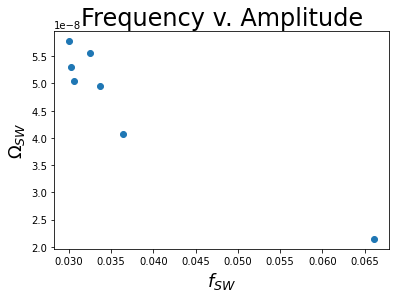

In [3]:
import sys
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
import generic_potential_modified
import tunneling1D_modified as tunneling1D
from cosmoTransitions import pathDeformation as pd_cosmo  # Avoid alias conflict

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

def get_f_max_and_width(b, c):
    T_c = 1 / np.sqrt(2 * (c - b**2))
    phi_minus = (-3 * b * T_c - np.sqrt(9 * b**2 * T_c**2 + 4 * (1 - 2 * c * T_c**2))) / 2
    Vtot = (-.5 + c * T_c**2) * phi_minus**2 + b * T_c * phi_minus**3 + .25 * phi_minus**4
    f_max = (Vtot / T_c**4) / 10
    width = 2 * phi_minus
    return f_max, width

class model1(generic_potential_modified.generic_potential):
    def init(self, a, b, c, Lambda, c1, f, width, **kwargs):
        self.Ndim = 1
        self.deriv_order = 2
        self.Tmax = 2.
        self.a = a
        self.b = b
        self.c = c
        self.Lambda = Lambda
        self.c1 = c1
        self.f = f
        self.width = width

    def approxZeroTMin(self):
        approxZeroGuess = 1.**2
        return [np.ones(self.Ndim) * approxZeroGuess**.5]

    def Vtot(self, X, T, include_radiation=True):
        X = np.asanyarray(X)
        phi = X[..., 0]
        w = (1 - 1 / (1 + np.exp(-self.c1 * (phi - self.width / 2)))) / (1 + np.exp(-self.c1 * (phi + self.width / 2)))
        w_0 = (1 - 1 / (1 + np.exp(-self.c1 * (0 - self.width / 2)))) / (1 + np.exp(-self.c1 * (0 + self.width / 2)))
        return ((-0.5 + self.c * T**2) * phi**2 + self.b * T * phi**3 + (0.25 + self.a) * phi**4 + self.f * T**4 * (w - w_0))

def get_profile(phi_vals, V_vals, guesses=(5, 0)):
    f = interpolate.UnivariateSpline(phi_vals, V_vals, s=0, k=4)
    df = f.derivative(1)
    d2f = f.derivative(2)
    inst = tunneling1D.SingleFieldInstanton(*guesses, f, df, d2f)
    profile = inst.findProfile()
    action = inst.findAction(profile)
    return profile, action

def get_thermal_params(Tnuc, f, param_instance):
    param_instance['f'] = f
    with HiddenPrints():
        try:
            m = model1(**param_instance)
            m.findAllTransitions(tunnelFromPhase_args={'verbose': False, 'fullTunneling_params': {'verbose': True}})
        except Exception as e:
            print(f"Error in model initialization or transition finding: {e}")
            return None

    try:
        trans_i = -1
        for Ti in range(np.size(m.TnTrans)):
            if m.TnTrans[Ti]['low_vev'][0] - m.TnTrans[Ti]['high_vev'][0] > 0:
                trans_i = Ti
        if trans_i == -1:
            print('No valid transition found')
            return None
        high_vev = m.TnTrans[trans_i]['high_vev'][0]
        low_vev = m.TnTrans[trans_i]['low_vev'][0]

        phis = np.linspace(high_vev - np.abs(high_vev), low_vev + np.abs(low_vev), num=10000)
        guesses = (low_vev + 0.01 * np.abs(low_vev), high_vev - 0.01 * np.abs(high_vev))
        V_vals = m.Vtot(np.array([phis]).T, Tnuc)
        profile, action = get_profile(phis, V_vals, guesses=guesses)
        ST = action / Tnuc

        # Calculate deltaV and its derivative
        Ts = np.linspace(Tnuc * 0.99, Tnuc * 1.01, num=100)
        deltaVs = np.array([m.Vtot(np.reshape(profile.Phi[-1], (1, 1)), T) - m.Vtot(np.reshape(profile.Phi[0], (1, 1)), T) for T in Ts])
        
        delV_spline = interpolate.UnivariateSpline(Ts, deltaVs, s=0, k=4)
        delV = delV_spline(Tnuc)
        ddelVdT = delV_spline.derivative(1)(Tnuc)

        # Correct calculation of rho_n
        rho_n = np.pi**2 * 10 * Tnuc**4 / 3

        ksi = 1 / rho_n * (delV - Tnuc * ddelVdT)

        # Calculate betaH
        try:
            action_Ts = np.array([get_profile(phis, m.Vtot(np.array([phis]).T, T), guesses)[1] for T in Ts])
            ST_spline = interpolate.UnivariateSpline(Ts, action_Ts / Ts, s=0, k=4)
            dSTdT = ST_spline.derivative(1)(Tnuc)
            betaH = dSTdT(Tnuc) * Tnuc
        except Exception as e:
            print(f'Error calculating betaH: {e}')
            betaH = 0

        return {
            'Tnucs': Tnuc,
            'betaHs': betaH,
            'ksis': ksi,
            'delV': delV,
            'ddelVdT': ddelVdT,
            'actions': action,
            'ST': ST
        }

    except Exception as e:
        print(f"Error in thermal parameter calculation: {e}")
        return None

# Seed with b, c, and analytic_tnuc from the analytic solution at f=0. 
# Shift f by some delta f
set_b = -1.54833
set_c = 4.51082
analytic_tnuc = 0.4553071346353729 

# Generate f values from 0 to -1.0
fs = np.arange(0.0, -1.1, -0.1)  

# Calculate the thermal parameters for a range of fs near f=0
def ideal_thermal_params(set_b, set_c, analytic_tnuc, fs):
    param_instance = {
        'a': 0,
        'b': set_b,
        'c': set_c,
        'Lambda': 1.,
        'c1': 20.,
        'f': 0,
        'width': get_f_max_and_width(set_b, set_c)[1]
    }

    all_thermal_params = []
    # Start with the analytic solution
    estimated_tnuc = analytic_tnuc  

    for f in fs:
        iteration = 0
        # After shifting f away from zero by our prescribed amount, we'll try to shift Tnuc by this initial amount
        adjustment_step = -0.005  # Negative adjustment step
        # We'll set a lower limit to avoid infinite iteration
        min_adjustment_step = -0.0001
        # Initialize to avoid UnboundLocalError (this is a hack for an error I don't really understand)
        interpolated_thermal_params = None

        initial_calculated_st = None

        while True:
            iteration += 1
            print(f"Iteration {iteration} for f={f}:")
            print(f"Current Tnuc: {estimated_tnuc}")
            
            # Calculate thermal params for the given f, Tnuc combo
            param_instance['f'] = f
            thermal_params = get_thermal_params(estimated_tnuc, f, param_instance)
            if thermal_params is None:
                print("Error calculating thermal parameters.")
                break

            priori_tnuc = thermal_params['Tnucs']
            calculated_st = thermal_params['ST']
            if initial_calculated_st is None:
                initial_calculated_st = calculated_st
            print(f"Calculated S/T: {calculated_st}")
            
            # Adjust Tnuc
            adjusted_tnuc = priori_tnuc + adjustment_step

            # Calculate params for this adjusted Tnuc
            param_instance['width'] = get_f_max_and_width(set_b, set_c)[1]
            thermal_params2 = get_thermal_params(adjusted_tnuc, f, param_instance)
            if thermal_params2 is None:
                print("Error calculating thermal parameters for adjusted Tnuc.")
                # If we fail to produce thermal parameters, let's try to adjust Tnuc by some smaller amount
                adjustment_step = .8 * adjustment_step 
                if adjustment_step > min_adjustment_step:
                    print("Minimum adjustment step size reached, exiting loop.")
                    break
                continue

            adjusted_st = thermal_params2['ST']
            #print(f"Adjusted S/T: {adjusted_st}\n\n")

            # Use linear interpolation to estimate Tnuc such that S/T is closer to 140
            try:
                estimate_tnuc = priori_tnuc + (140 - calculated_st) * ((adjusted_tnuc - priori_tnuc) / (adjusted_st - calculated_st))
                interpolated_thermal_params = get_thermal_params(estimate_tnuc, f, param_instance)
                if interpolated_thermal_params is None:
                    print("Error calculating interpolated thermal parameters.")
                    # If we fail, retry with smaller adjustment
                    adjustment_step = .8 * adjustment_step  
                    if adjustment_step > min_adjustment_step:
                        print("Minimum adjustment step size reached, exiting loop.")
                        break
                    continue

                estimate_st = interpolated_thermal_params['ST']
                print(f"Estimated Tnuc: {estimate_tnuc}")
                print(f"Estimated S/T: {estimate_st}\n")
            except Exception as e:
                print(f"Error during interpolation: {e}")
                # If we fail, retry with smaller adjustment
                adjustment_step = .8 * adjustment_step
                if adjustment_step > min_adjustment_step:
                    print("Minimum adjustment step size reached, exiting loop.")
                    break
                continue

            # Track the differences in S/T
            combo_1_diff = np.abs(140 - calculated_st)
            combo_2_diff = np.abs(140 - adjusted_st)
            combo_3_diff = np.abs(140 - estimate_st)

            diffs = [combo_1_diff, combo_2_diff, combo_3_diff]
            
            # Break the loop when the difference is within the threshold
            if any(diff < 1 for diff in diffs):
                print(f"Target Tnuc for f={f}: {estimate_tnuc}")
                # Use the estimated Tnuc as the seed Tnuc for the next f value
                estimated_tnuc = estimate_tnuc 
                break

            # Use old estimate as new seed
            estimated_tnuc = estimate_tnuc
            
            # Dodge infinite loop
            if iteration > 10:  
                print("Exceeded maximum iterations, exiting loop.")
                break

        if interpolated_thermal_params is not None:
            all_thermal_params.append({
                'f': f,
                'Tnucs': interpolated_thermal_params['Tnucs'],
                'betaHs': interpolated_thermal_params['betaHs'],
                'ksis': interpolated_thermal_params['ksis'],
                'delV': interpolated_thermal_params['delV'],
                'ddelVdT': interpolated_thermal_params['ddelVdT'],
                'actions': interpolated_thermal_params['actions'],
                'ST': interpolated_thermal_params['ST'],
                'initial_calculated_st': initial_calculated_st,
                'estimate_st': estimate_st,
                'adjustment_step': adjustment_step
            })

    return all_thermal_params

# Calculate the thermal parameters for the range of f values
thermal_params_list = ideal_thermal_params(set_b, set_c, analytic_tnuc, fs)

# Convert to a Pandas DataFrame for easier manipulation and saving
df_thermal_params = pd.DataFrame(thermal_params_list)

print(df_thermal_params)

# Calculate slopes
slope_list = []
for i in range(len(df_thermal_params)):
    if 'initial_calculated_st' in df_thermal_params.columns and 'estimate_st' in df_thermal_params.columns:
        st_difference = df_thermal_params['estimate_st'][i] - df_thermal_params['initial_calculated_st'][i]
        slope = st_difference / df_thermal_params['adjustment_step'][i]
        slope_list.append(slope)
    
print("Slopes:", slope_list)

# Calculate Beta_H
Beta_H_list = []
for i in range(len(slope_list)):
    Beta_H = slope_list[i] * df_thermal_params['Tnucs'][i]
    Beta_H_list.append(Beta_H)
    
print("Beta_H values:", Beta_H_list)

# Calculate h^2 Omega and f_SW
h_2_omega_list = []
f_SW_list = []
for i in range(len(Beta_H_list)):
    h_2_omega = (8.5 * 10**-6) * df_thermal_params['ksis'][i]**4 * Beta_H_list[i]**-1
    f_sw = (8.9 * 10**-3) * Beta_H_list[i]
    f_SW = f_sw * df_thermal_params['Tnucs'][i] / 100
    h_2_omega_list.append(h_2_omega)
    f_SW_list.append(f_SW)
    
print("h^2 Omega values:", h_2_omega_list)
print("f_SW values:", f_SW_list)

# Plotting the results
plt.scatter(f_SW_list, h_2_omega_list)
plt.xlabel(r'$f_{SW}$', size=18)
plt.ylabel(r'$\Omega_{SW}$', size=18)
plt.title('Frequency v. Amplitude', size=24)
plt.show()